In [126]:
from pathlib import Path
from itertools import combinations
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_auc_score, pairwise_distances, accuracy_score
import torch
import torch.optim as optim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import scipy.sparse as sp
from numba import jit
from Annotatability import models
from Annotatability import metrics
import scvi
import logging
import squidpy as sq
logging.getLogger("scvi").setLevel(logging.WARNING)

SMALL_SIZE = 16
MEDIUM_SIZE = 20.5
BIGGER_SIZE = 24
#plt.rcParams["font.family"] = "Verdana"
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sc.set_figure_params(scanpy=True, fontsize=20.5)

# Define custom color palette
annotation_order = ['Easy-to-learn', 'Ambiguous', 'Hard-to-learn']
annotation_colors = ['green', 'orange', 'red']
palette = dict(zip(annotation_order, annotation_colors))

# PBMC Dataset

In [127]:
# Load and preprocess the data
adata_pbmc = scvi.data.pbmc_dataset()
# Filter out infrequent cell type (Megakaryocytes)
adata_pbmc = adata_pbmc[adata_pbmc.obs['str_labels'].isin(['B cells', 'CD4 T cells', 'CD8 T cells', 'CD14+ Monocytes', 'Dendritic Cells', 'FCGR3A+ Monocytes', 'NK cells'])] 
sc.pp.normalize_per_cell(adata_pbmc, counts_per_cell_after=1e4)
sc.pp.log1p(adata_pbmc)

## Confidence vs Variability in PBMC (Epochs = 100)

In [128]:
# Define functions for PBMC analysis

def train_and_get_prob_list(adata, label_key, epoch_num, device=device, batch_size=128):
    prob_list = models.follow_training_dyn_neural_net(adata, label_key=label_key, iterNum=epoch_num, device=device, batch_size=batch_size)
    return prob_list

def calculate_confidence_and_variability(prob_list, n_obs, epoch_num):
    all_conf, all_var = models.probability_list_to_confidence_and_var(prob_list, n_obs=n_obs, epoch_num=epoch_num)
    return all_conf, all_var

def find_cutoffs(adata, label_key, device, probability, percentile, epoch_num):
    cutoff_conf, cutoff_var = models.find_cutoff_paramter(adata, label_key, device, probability=probability, percentile=percentile, epoch_num=epoch_num)
    return cutoff_conf, cutoff_var

def assign_annotations(adata, all_conf, all_var, cutoff_conf, cutoff_var, annotation_col='Annotation'):
    adata.obs["var"] = all_var.detach().numpy()
    adata.obs["conf"] = all_conf.detach().numpy()
    adata.obs['conf_binaries'] = pd.Categorical((adata.obs['conf'] > cutoff_conf) | (adata.obs['var'] > cutoff_var))

    annotation_list = []
    for i in range(adata.n_obs):
        if adata.obs['conf_binaries'].iloc[i]:
            if (adata.obs['conf'].iloc[i] > 0.95) & (adata.obs['var'].iloc[i] < 0.15):
                annotation_list.append('Easy-to-learn', 'Ambiguous', 'Hard-to-learn')
            else:
                annotation_list.append('Ambiguous')
        else:
            annotation_list.append('Hard-to-learn')

    adata.obs[annotation_col] = annotation_list
    adata.obs['Confidence'] = adata.obs['conf']
    adata.obs['Variability'] = adata.obs['var']
    return adata

# Parameters
epoch_num_pbmc_original = 100
percentile_pbmc = 25

# Training and getting probability list
prob_list_pbmc_original = train_and_get_prob_list(adata_pbmc, label_key='str_labels', epoch_num=epoch_num_pbmc_original)

# Calculating confidence and variability
all_conf_pbmc, all_var_pbmc = calculate_confidence_and_variability(prob_list_pbmc_original, n_obs=adata_pbmc.n_obs, epoch_num=epoch_num_pbmc_original)

# Finding cutoffs
cutoff_conf_pbmc, cutoff_var_pbmc = find_cutoffs(adata_pbmc, 'str_labels', device, probability=0.1, percentile=percentile_pbmc, epoch_num=epoch_num_pbmc_original)

# Assign annotations
adata_pbmc = assign_annotations(adata_pbmc, all_conf_pbmc, all_var_pbmc, cutoff_conf_pbmc, cutoff_var_pbmc, annotation_col='Annotation')

[1,     2] loss: 0.395
[1,    12] loss: 1.940
[1,    22] loss: 1.873
[1,    32] loss: 1.792
[1,    42] loss: 1.700
[1,    52] loss: 1.583
[1,    62] loss: 1.448
[1,    72] loss: 1.294
[1,    82] loss: 1.143
[2,     2] loss: 0.191
[2,    12] loss: 0.862
[2,    22] loss: 0.764
[2,    32] loss: 0.676
[2,    42] loss: 0.592
[2,    52] loss: 0.514
[2,    62] loss: 0.454
[2,    72] loss: 0.431
[2,    82] loss: 0.368
[3,     2] loss: 0.066
[3,    12] loss: 0.300
[3,    22] loss: 0.295
[3,    32] loss: 0.273
[3,    42] loss: 0.262
[3,    52] loss: 0.235
[3,    62] loss: 0.225
[3,    72] loss: 0.205
[3,    82] loss: 0.184
[4,     2] loss: 0.041
[4,    12] loss: 0.208
[4,    22] loss: 0.158
[4,    32] loss: 0.177
[4,    42] loss: 0.168
[4,    52] loss: 0.146
[4,    62] loss: 0.134
[4,    72] loss: 0.161
[4,    82] loss: 0.153
[5,     2] loss: 0.034
[5,    12] loss: 0.138
[5,    22] loss: 0.140
[5,    32] loss: 0.120
[5,    42] loss: 0.102
[5,    52] loss: 0.135
[5,    62] loss: 0.100
[5,    72] 

# Merfish Dataset

In [129]:
# Load and preprocess the data
adata_merfish = sq.datasets.merfish()
sc.pp.normalize_per_cell(adata_merfish, counts_per_cell_after=1e4)
sc.pp.log1p(adata_merfish)

# Map clusters to cell types
cell_type_mapping = {
    'OD Mature 2': 'OD Mature',
    'OD Immature 1': 'OD Immature',
    'Inhibitory': 'Inhibitory',
    'Excitatory': 'Excitatory',
    'Microglia': 'Microglia',
    'Astrocyte': 'Astrocyte',
    'Endothelial 2': 'Endothelial',
    'Endothelial 3': 'Endothelial',
    'Endothelial 1': 'Endothelial',
    'OD Mature 1': 'OD Mature',
    'OD Mature 4': 'OD Mature',
    'Pericytes': 'Pericytes',
    'OD Mature 3': 'OD Mature',
    'Ependymal': 'Ependymal',
    'OD Immature 2': 'OD Immature'
}
adata_merfish.obs['CellType'] = adata_merfish.obs['Cell_class'].map(cell_type_mapping).fillna(adata_merfish.obs['Cell_class'])

## Confidence vs Variability in Merfish (Epochs = 150)

In [130]:
# Use the functions defined earlier for Merfish analysis

# Parameters
epoch_num_merfish_original = 150
percentile_merfish = 90

# Training and getting probability list
prob_list_merfish_original = train_and_get_prob_list(adata_merfish, label_key='CellType', epoch_num=epoch_num_merfish_original, batch_size=64)

# Calculating confidence and variability
all_conf_merfish, all_var_merfish = calculate_confidence_and_variability(prob_list_merfish_original, n_obs=adata_merfish.n_obs, epoch_num=epoch_num_merfish_original)

# Finding cutoffs
cutoff_conf_merfish, cutoff_var_merfish = find_cutoffs(adata_merfish, 'CellType', device, probability=0.1, percentile=percentile_merfish, epoch_num=epoch_num_merfish_original)

# Assign annotations
adata_merfish = assign_annotations(adata_merfish, all_conf_merfish, all_var_merfish, cutoff_conf_merfish, cutoff_var_merfish, annotation_col='Annotation')

[1,     2] loss: 0.466
[1,    12] loss: 2.325
[1,    22] loss: 2.298
[1,    32] loss: 2.242
[1,    42] loss: 2.198
[1,    52] loss: 2.174
[1,    62] loss: 2.122
[1,    72] loss: 2.082
[1,    82] loss: 2.030
[1,    92] loss: 1.966
[1,   102] loss: 1.913
[1,   112] loss: 1.842
[1,   122] loss: 1.741
[1,   132] loss: 1.674
[1,   142] loss: 1.593
[1,   152] loss: 1.516
[1,   162] loss: 1.448
[1,   172] loss: 1.331
[1,   182] loss: 1.253
[1,   192] loss: 1.260
[1,   202] loss: 1.146
[1,   212] loss: 1.107
[1,   222] loss: 1.020
[1,   232] loss: 0.981
[1,   242] loss: 0.929
[1,   252] loss: 0.940
[1,   262] loss: 0.842
[1,   272] loss: 0.790
[1,   282] loss: 0.795
[1,   292] loss: 0.763
[1,   302] loss: 0.765
[1,   312] loss: 0.710
[1,   322] loss: 0.655
[1,   332] loss: 0.675
[1,   342] loss: 0.703
[1,   352] loss: 0.642
[1,   362] loss: 0.658
[1,   372] loss: 0.654
[1,   382] loss: 0.659
[1,   392] loss: 0.553
[1,   402] loss: 0.555
[1,   412] loss: 0.608
[1,   422] loss: 0.591
[1,   432] 

## Confidence vs Variability

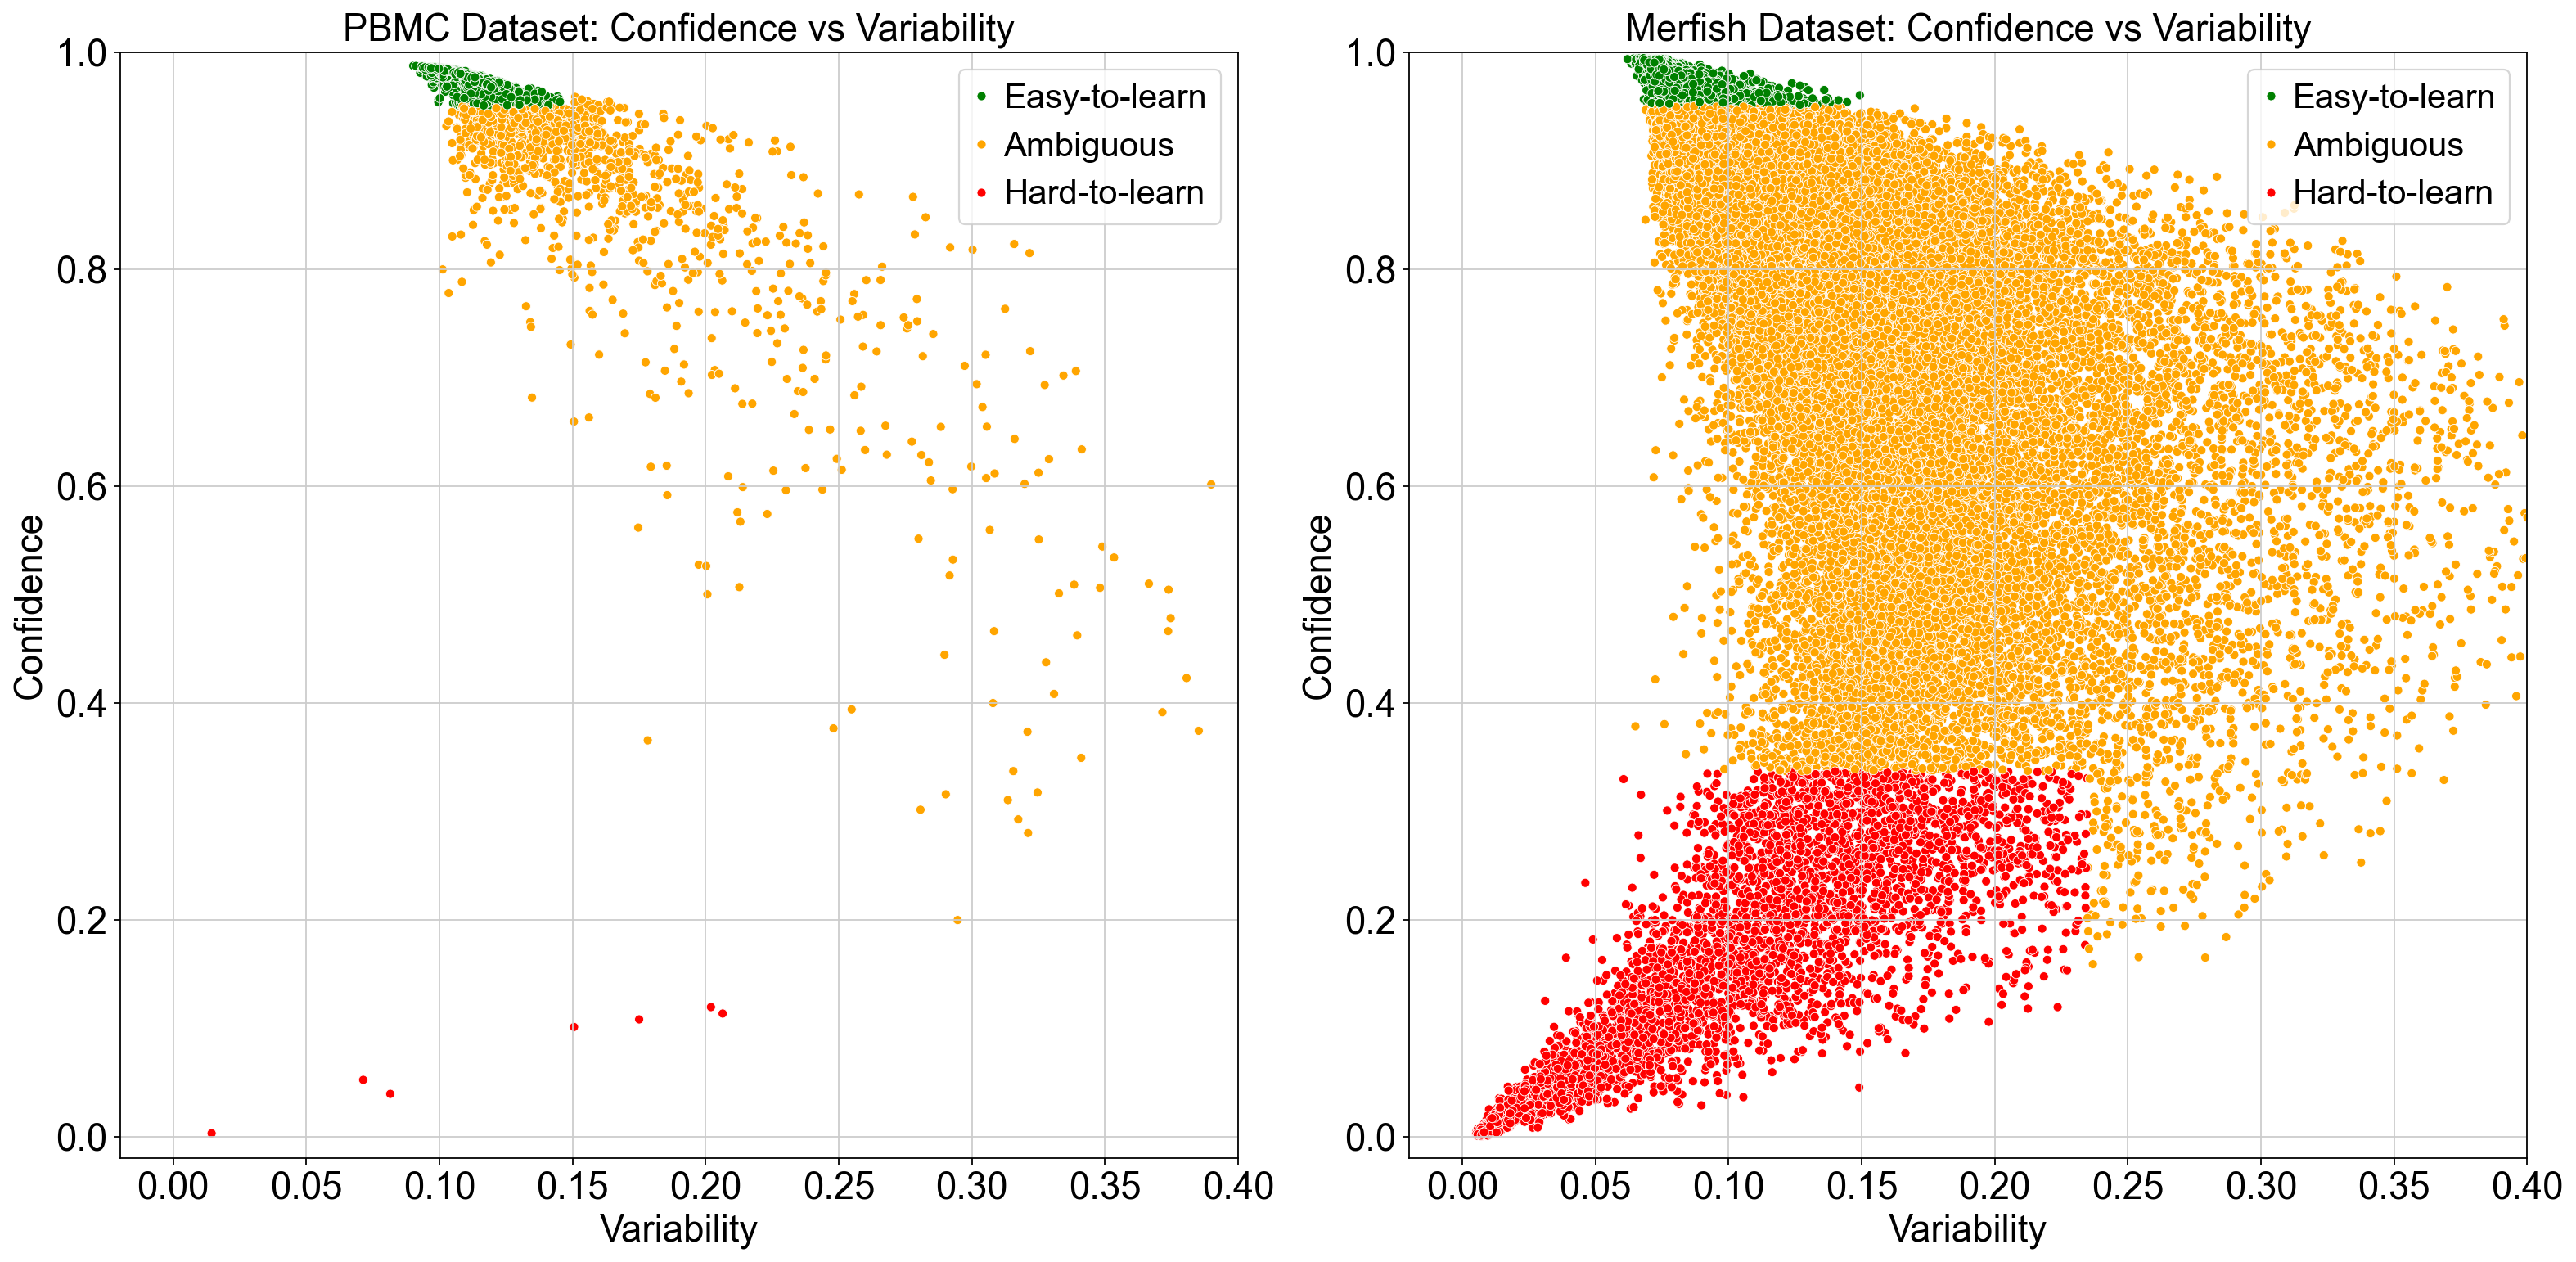

In [131]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# PBMC Plot
sns.scatterplot(
    data=adata_pbmc.obs,
    x="Variability",
    y="Confidence",
    hue='Annotation',
    hue_order=annotation_order,
    palette=palette,
    ax=axes[0],
    s=25
)
axes[0].set_title('PBMC Dataset: Confidence vs Variability')
axes[0].set_xlim(-0.02, 0.4)
axes[0].set_ylim(-0.02, 1)

# Merfish Plot
sns.scatterplot(
    data=adata_merfish.obs,
    x="Variability",
    y="Confidence",
    hue='Annotation',
    hue_order=annotation_order,
    palette=palette,
    ax=axes[1],
    s=25
)
axes[1].set_title('Merfish Dataset: Confidence vs Variability')
axes[1].set_xlim(-0.02, 0.4)
axes[1].set_ylim(-0.02, 1)

# Adjust legends
axes[0].legend(loc='upper right')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

# Experimenting with Different Cutoff Parameters

In [142]:
def experiment_cutoffs(adata, prob_list, label_key, epoch_num, q_values, dataset_name):
    results = []
    for q in q_values:
        # Calculate cutoffs
        cutoff_conf, cutoff_var = models.find_cutoff_paramter(
            adata, label_key, device=device, probability=0.1, percentile=q, epoch_num=epoch_num
        )
        # Compute confidence and variability
        all_conf, all_var = models.probability_list_to_confidence_and_var(
            prob_list, n_obs=adata.n_obs, epoch_num=epoch_num
        )
        # Apply the cutoff_conf and cutoff_var
        conf_binaries = ((all_conf > cutoff_conf) | (all_var > cutoff_var))
        annotations = []
        for i in range(adata.n_obs):
            if conf_binaries[i]:
                if (all_conf[i] > 0.95) & (all_var[i] < 0.15):
                    annotations.append('Easy-to-learn')
                else:
                    annotations.append('Ambiguous')
            else:
                annotations.append('Hard-to-learn')
        # Count the number of samples in each group
        counts = pd.Series(annotations).value_counts()
        results.append({
            'q': q,
            'Easy-to-learn': counts.get('Easy-to-learn', 0),
            'Ambiguous': counts.get('Ambiguous', 0),
            'Hard-to-learn': counts.get('Hard-to-learn', 0)
        })
    # Create DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [143]:
# Experiment on PBMC Dataset

# Define range of q values
q_values = range(25, 91, 5)  # From 25% to 90% with step of 5%

# Run experiment
results_pbmc = experiment_cutoffs(adata_pbmc, prob_list_pbmc_original, 'str_labels', epoch_num_pbmc_original, q_values, 'PBMC')

[1,     2] loss: 0.389
[1,    12] loss: 1.936
[1,    22] loss: 1.905
[1,    32] loss: 1.859
[1,    42] loss: 1.808
[2,     2] loss: 0.354
[2,    12] loss: 1.723
[2,    22] loss: 1.666
[2,    32] loss: 1.587
[2,    42] loss: 1.507
[3,     2] loss: 0.291
[3,    12] loss: 1.389
[3,    22] loss: 1.331
[3,    32] loss: 1.245
[3,    42] loss: 1.205
[4,     2] loss: 0.225
[4,    12] loss: 1.170
[4,    22] loss: 1.094
[4,    32] loss: 1.079
[4,    42] loss: 1.028
[5,     2] loss: 0.191
[5,    12] loss: 1.022
[5,    22] loss: 0.995
[5,    32] loss: 1.010
[5,    42] loss: 0.964
[6,     2] loss: 0.176
[6,    12] loss: 0.965
[6,    22] loss: 0.909
[6,    32] loss: 0.911
[6,    42] loss: 0.901
[7,     2] loss: 0.177
[7,    12] loss: 0.922
[7,    22] loss: 0.893
[7,    32] loss: 0.859
[7,    42] loss: 0.841
[8,     2] loss: 0.178
[8,    12] loss: 0.868
[8,    22] loss: 0.914
[8,    32] loss: 0.815
[8,    42] loss: 0.831
[9,     2] loss: 0.168
[9,    12] loss: 0.799
[9,    22] loss: 0.847
[9,    32] 

In [144]:
# Experiment on Merfish Dataset

# Run experiment
results_merfish = experiment_cutoffs(adata_merfish, prob_list_merfish_original, 'CellType', epoch_num_merfish_original, q_values, 'Merfish')

[1,     2] loss: 0.467
[1,    12] loss: 2.332
[1,    22] loss: 2.305
[1,    32] loss: 2.292
[1,    42] loss: 2.268
[1,    52] loss: 2.259
[1,    62] loss: 2.241
[1,    72] loss: 2.224
[1,    82] loss: 2.212
[1,    92] loss: 2.187
[1,   102] loss: 2.178
[1,   112] loss: 2.147
[1,   122] loss: 2.125
[1,   132] loss: 2.094
[1,   142] loss: 2.063
[1,   152] loss: 2.044
[1,   162] loss: 1.997
[1,   172] loss: 1.962
[1,   182] loss: 1.910
[1,   192] loss: 1.874
[1,   202] loss: 1.835
[1,   212] loss: 1.757
[1,   222] loss: 1.737
[1,   232] loss: 1.699
[1,   242] loss: 1.659
[1,   252] loss: 1.585
[1,   262] loss: 1.620
[1,   272] loss: 1.564
[1,   282] loss: 1.522
[2,     2] loss: 0.308
[2,    12] loss: 1.490
[2,    22] loss: 1.493
[2,    32] loss: 1.426
[2,    42] loss: 1.452
[2,    52] loss: 1.432
[2,    62] loss: 1.455
[2,    72] loss: 1.380
[2,    82] loss: 1.400
[2,    92] loss: 1.420
[2,   102] loss: 1.379
[2,   112] loss: 1.364
[2,   122] loss: 1.313
[2,   132] loss: 1.384
[2,   142] 

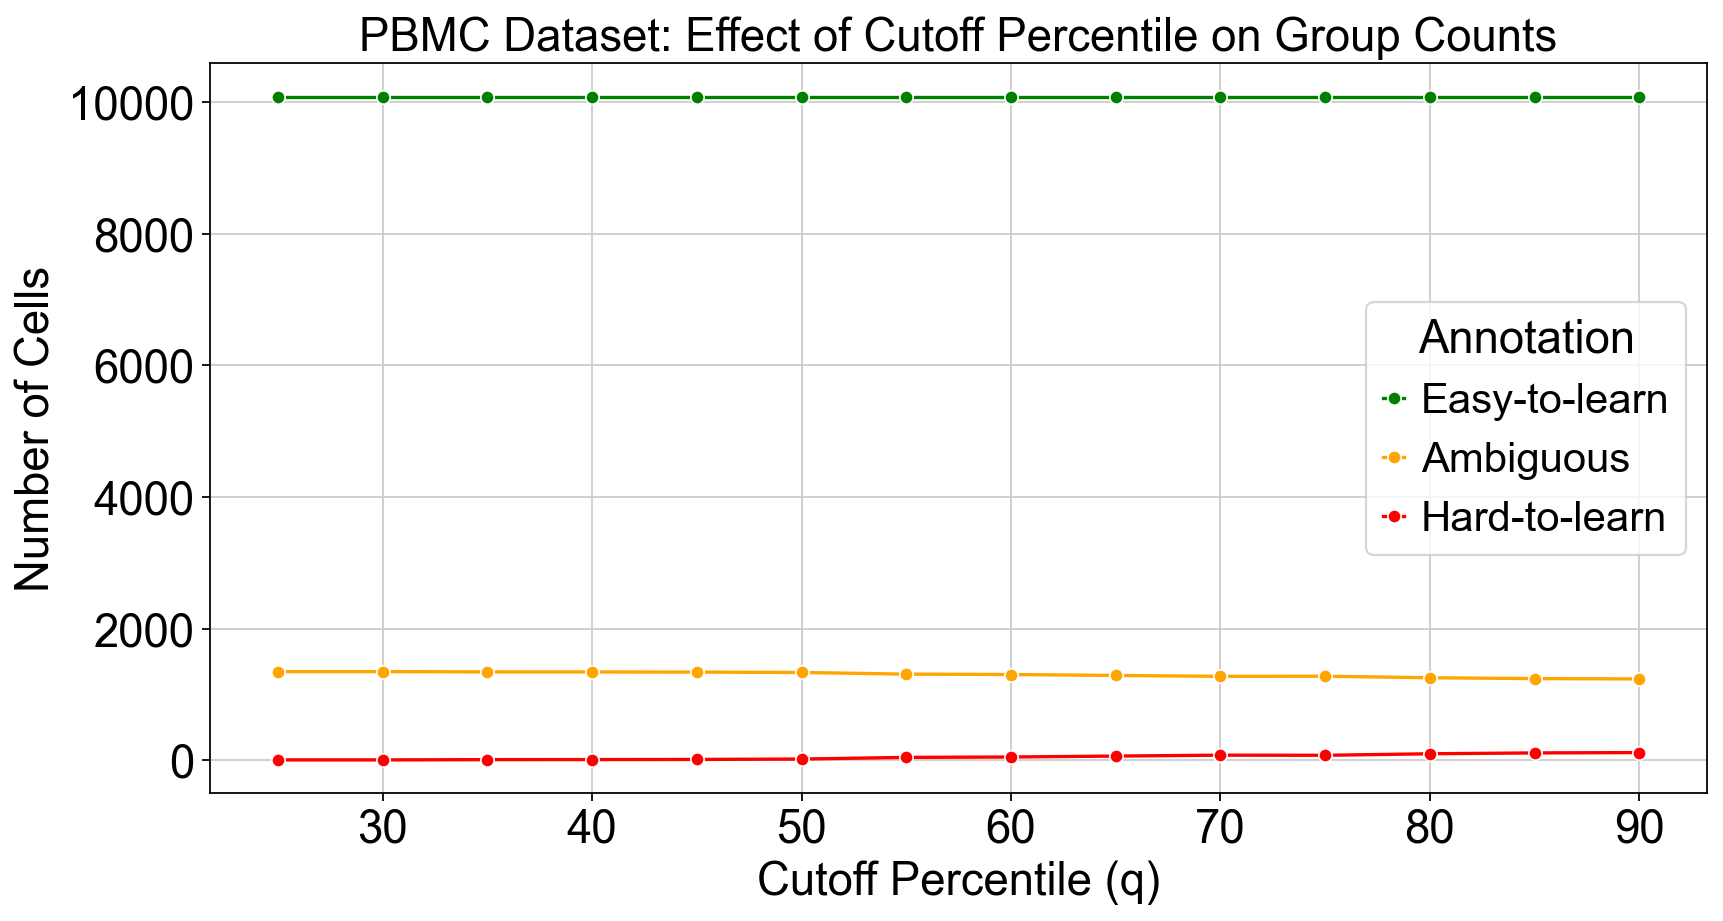

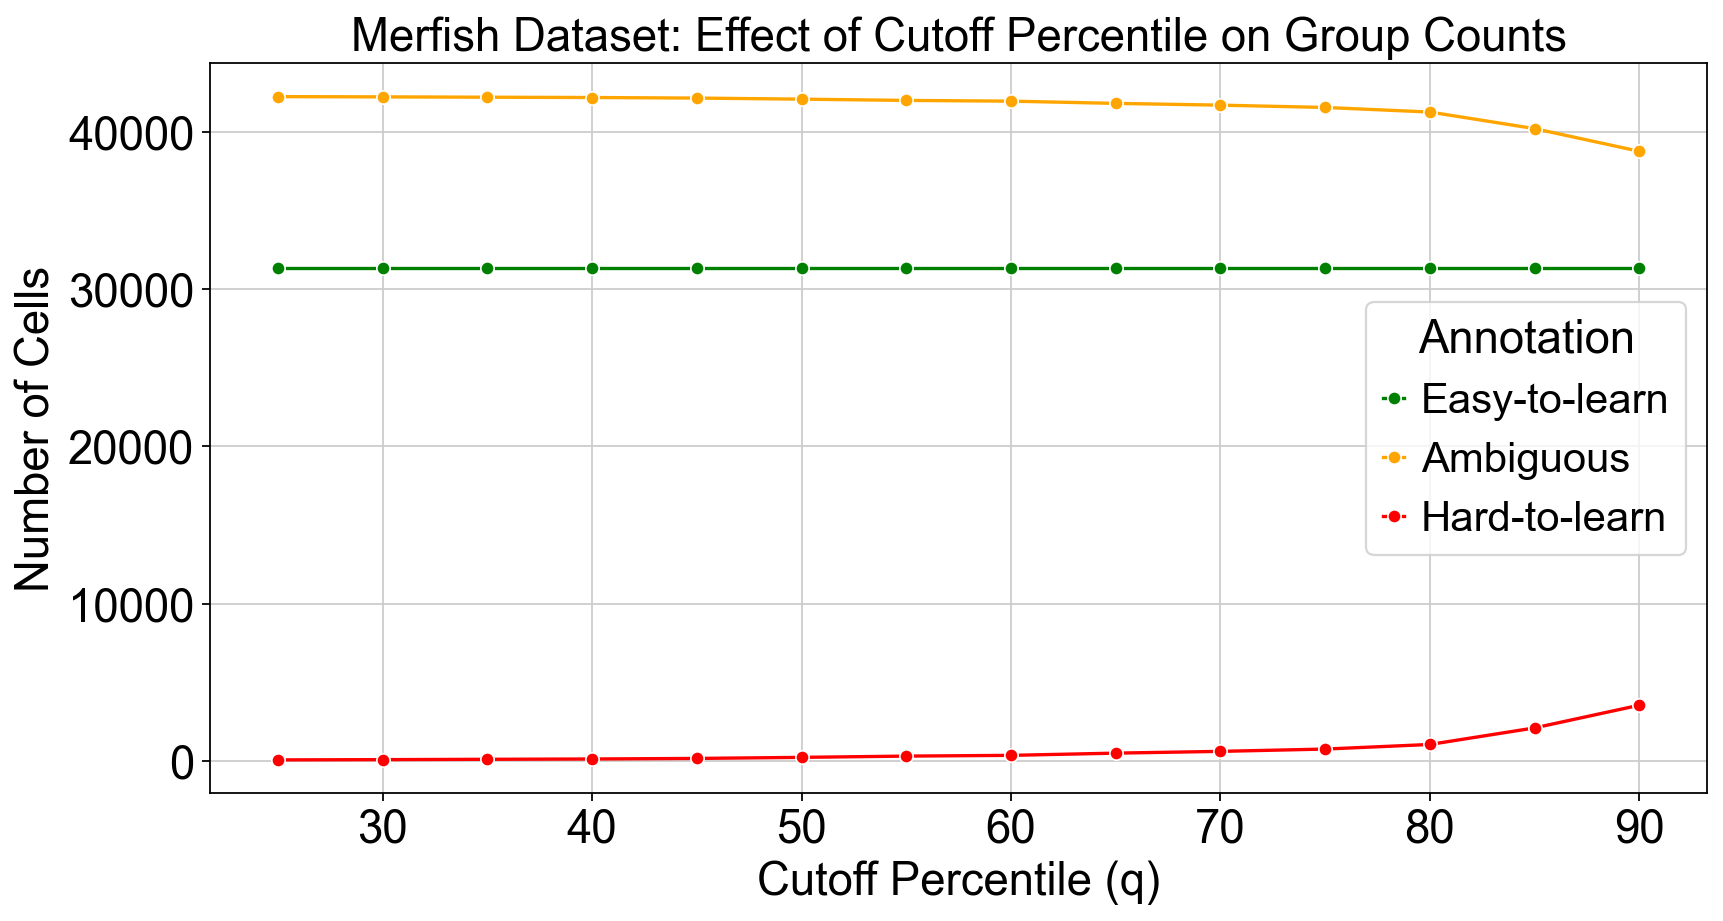

In [145]:
# Visualization: Effect of Cutoff Percentile on Group Counts

# For PBMC Dataset
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results_pbmc.melt(id_vars=['q'], var_name='Annotation', value_name='Count'),
    x='q',
    y='Count',
    hue='Annotation',
    marker='o',
    hue_order=annotation_order,
    palette=palette
)
plt.title('PBMC Dataset: Effect of Cutoff Percentile on Group Counts')
plt.xlabel('Cutoff Percentile (q)')
plt.ylabel('Number of Cells')
plt.show()

# For Merfish Dataset
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results_merfish.melt(id_vars=['q'], var_name='Annotation', value_name='Count'),
    x='q',
    y='Count',
    hue='Annotation',
    marker='o',
    hue_order=annotation_order,
    palette=palette
)
plt.title('Merfish Dataset: Effect of Cutoff Percentile on Group Counts')
plt.xlabel('Cutoff Percentile (q)')
plt.ylabel('Number of Cells')
plt.show()

# Distribution of Groups per Epoch (Epochs = 200)

In [138]:
# Define function to calculate group counts per epoch
def calculate_group_counts_per_epoch(adata, prob_list, label_key, cutoff_conf, cutoff_var, epoch_num, percentile):
    group_counts = {'Easy-to-learn': [], 'Ambiguous': [], 'Hard-to-learn': []}

    for epoch in range(1, epoch_num + 1):
        # Get probabilities up to this epoch
        prob_list_epoch = prob_list[:epoch]
        # Compute confidence and variability up to this epoch
        all_conf, all_var = calculate_confidence_and_variability(prob_list_epoch, n_obs=adata.n_obs, epoch_num=epoch)
        # Apply the cutoff_conf and cutoff_var
        conf_binaries = ((all_conf > cutoff_conf) | (all_var > cutoff_var))
        annotations = []
        for i in range(adata.n_obs):
            if conf_binaries[i]:
                if (all_conf[i] > 0.95) & (all_var[i] < 0.15):
                    annotations.append('Easy-to-learn')
                else:
                    annotations.append('Ambiguous')
            else:
                annotations.append('Hard-to-learn')
        # Count the number of samples in each group
        counts = pd.Series(annotations).value_counts()
        for group in group_counts:
            group_counts[group].append(counts.get(group, 0))
    # Create DataFrame for group counts
    group_counts_df = pd.DataFrame(group_counts)
    group_counts_df['Epoch'] = range(1, epoch_num + 1)
    return group_counts_df

# For PBMC Dataset
epoch_num_pbmc_new = 200

# Training and getting probability list
prob_list_pbmc_new = train_and_get_prob_list(adata_pbmc, label_key='str_labels', epoch_num=epoch_num_pbmc_new)

# Using previous cutoffs
cutoff_conf_pbmc_new, cutoff_var_pbmc_new = find_cutoffs(adata_pbmc, 'str_labels', device, probability=0.1, percentile=percentile_pbmc, epoch_num=epoch_num_pbmc_new)

# Calculate group counts per epoch
group_counts_df_pbmc = calculate_group_counts_per_epoch(adata_pbmc, prob_list_pbmc_new, 'str_labels', cutoff_conf_pbmc_new, cutoff_var_pbmc_new, epoch_num_pbmc_new, percentile_pbmc)

# For Merfish Dataset
epoch_num_merfish_new = 200

# Training and getting probability list
prob_list_merfish_new = train_and_get_prob_list(adata_merfish, label_key='CellType', epoch_num=epoch_num_merfish_new, batch_size=64)

# Using previous cutoffs
cutoff_conf_merfish_new, cutoff_var_merfish_new = find_cutoffs(adata_merfish, 'CellType', device, probability=0.1, percentile=percentile_merfish, epoch_num=epoch_num_merfish_new)

# Calculate group counts per epoch
group_counts_df_merfish = calculate_group_counts_per_epoch(adata_merfish, prob_list_merfish_new, 'CellType', cutoff_conf_merfish_new, cutoff_var_merfish_new, epoch_num_merfish_new, percentile_merfish)


[1,     2] loss: 0.391
[1,    12] loss: 1.934
[1,    22] loss: 1.863
[1,    32] loss: 1.785
[1,    42] loss: 1.680
[1,    52] loss: 1.566
[1,    62] loss: 1.435
[1,    72] loss: 1.287
[1,    82] loss: 1.127
[2,     2] loss: 0.184
[2,    12] loss: 0.851
[2,    22] loss: 0.730
[2,    32] loss: 0.643
[2,    42] loss: 0.565
[2,    52] loss: 0.502
[2,    62] loss: 0.453
[2,    72] loss: 0.402
[2,    82] loss: 0.357
[3,     2] loss: 0.063
[3,    12] loss: 0.310
[3,    22] loss: 0.254
[3,    32] loss: 0.269
[3,    42] loss: 0.239
[3,    52] loss: 0.215
[3,    62] loss: 0.208
[3,    72] loss: 0.220
[3,    82] loss: 0.223
[4,     2] loss: 0.034
[4,    12] loss: 0.182
[4,    22] loss: 0.177
[4,    32] loss: 0.162
[4,    42] loss: 0.171
[4,    52] loss: 0.153
[4,    62] loss: 0.153
[4,    72] loss: 0.144
[4,    82] loss: 0.160
[5,     2] loss: 0.023
[5,    12] loss: 0.137
[5,    22] loss: 0.118
[5,    32] loss: 0.137
[5,    42] loss: 0.128
[5,    52] loss: 0.138
[5,    62] loss: 0.123
[5,    72] 

## Visualization: Distribution of Groups per Epoch

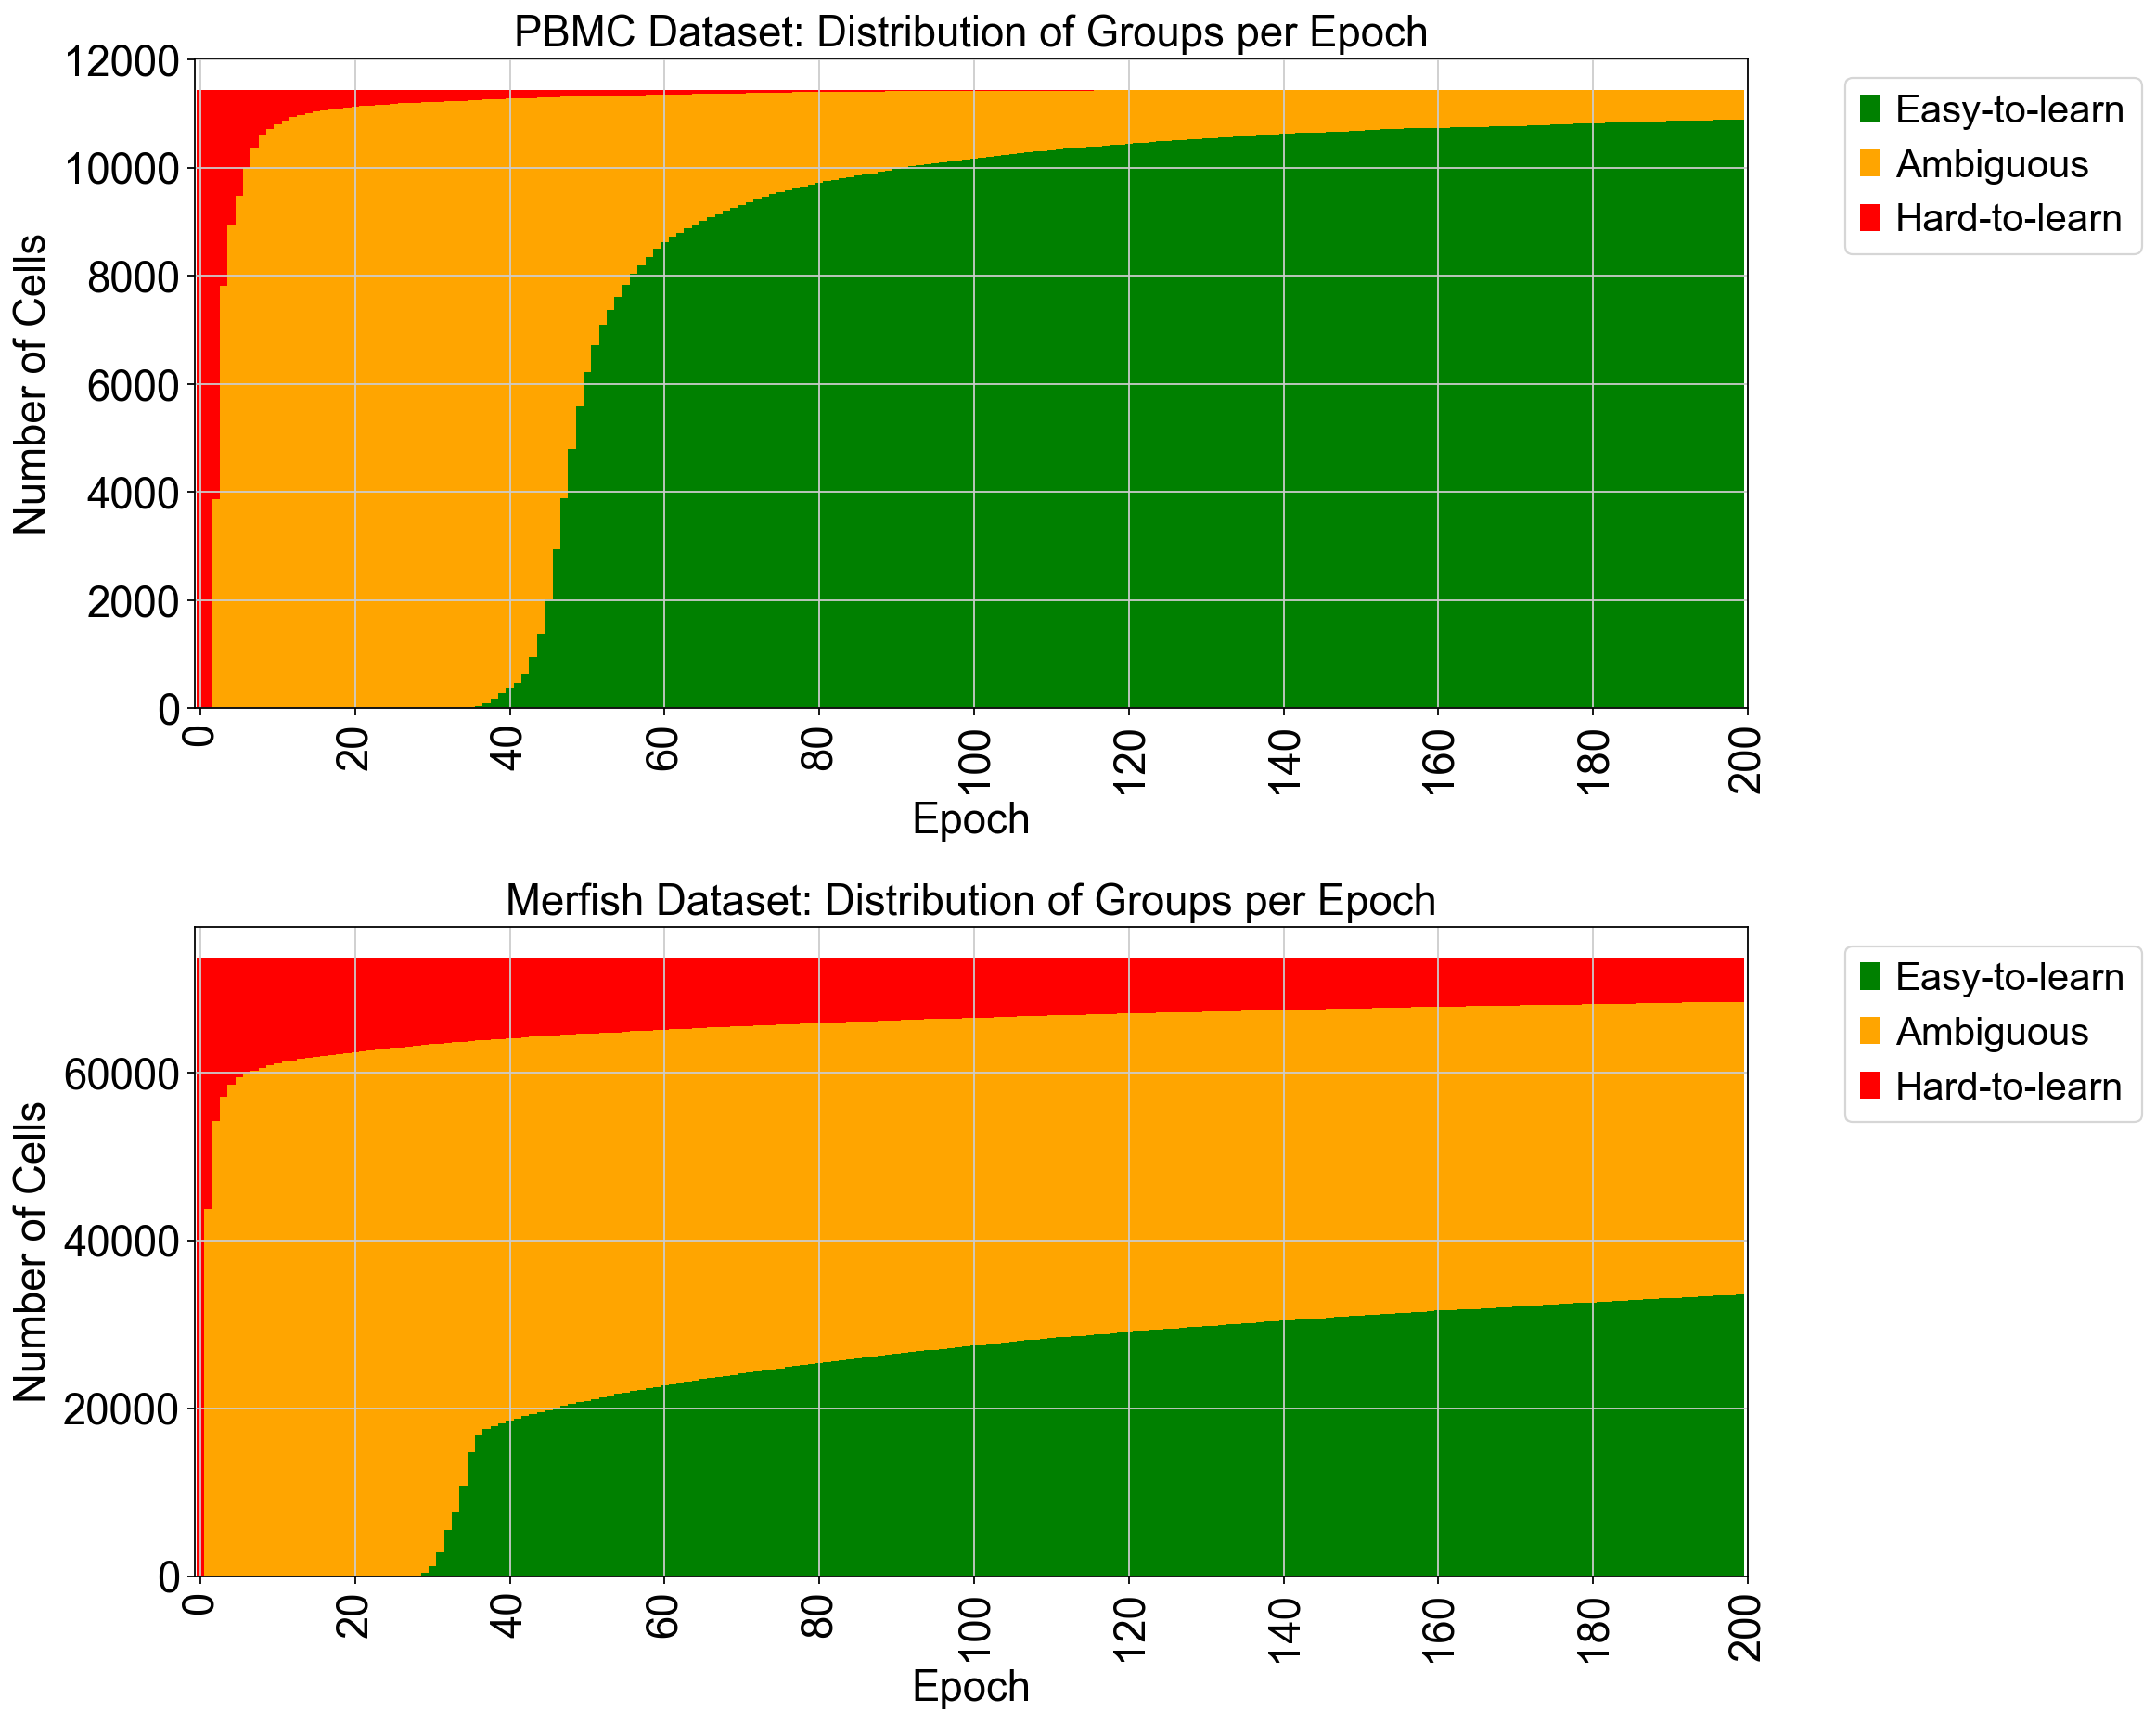

In [139]:
# Define custom color palette for bar charts
bar_colors = ['green', 'orange', 'red']

# Create a figure with two subplots stacked vertically
fig, axs = plt.subplots(2, 1, figsize=(15, 12), sharex=False)

# Plot for PBMC
group_counts_df_pbmc.set_index('Epoch')[['Easy-to-learn', 'Ambiguous', 'Hard-to-learn']].plot(
    kind='bar', stacked=True, ax=axs[0], color=bar_colors, width=1)
axs[0].set_title('PBMC Dataset: Distribution of Groups per Epoch')
axs[0].set_ylabel('Number of Cells')
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].set_xlabel('Epoch')
axs[0].set_xticks(range(0, epoch_num_pbmc_new + 1, 20))
axs[0].set_xticklabels(range(0, epoch_num_pbmc_new + 1, 20))

# Plot for Merfish
group_counts_df_merfish.set_index('Epoch')[['Easy-to-learn', 'Ambiguous', 'Hard-to-learn']].plot(
    kind='bar', stacked=True, ax=axs[1], color=bar_colors, width=1)
axs[1].set_title('Merfish Dataset: Distribution of Groups per Epoch')
axs[1].set_ylabel('Number of Cells')
axs[1].set_xlabel('Epoch')
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[1].set_xticks(range(0, epoch_num_merfish_new + 1, 20))
axs[1].set_xticklabels(range(0, epoch_num_merfish_new + 1, 20))

plt.tight_layout()
plt.show()

# Section: Model Performance vs. Training Data Composition

In [140]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import scanpy as sc
import scipy.sparse as sp
from Annotatability.models import Net, is_scipy_cs_sparse

# Ensure device is set properly (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define evaluate_model_performance_by_group function
def evaluate_model_performance_by_group(adata, label_key, annotations, dataset_name):
    # Prepare data
    X = adata.X
    y = adata.obs[label_key].values
    annotation_labels = adata.obs[annotations].values

    # Split into train and test
    X_train_full, X_test, y_train_full, y_test, annot_train_full, annot_test = train_test_split(
        X, y, annotation_labels, test_size=0.2, random_state=42, stratify=y
    )

    # Create label encoder on the full training labels
    label_encoder_full = LabelEncoder()
    label_encoder_full.fit(y_train_full)
    num_classes = len(label_encoder_full.classes_)

    # Proportions of each group to use
    group_labels = ['Easy-to-learn', 'Ambiguous', 'Hard-to-learn']
    group_proportions = np.linspace(0.1, 1.0, 5)

    # Store results
    results = []

    for group in group_labels:
        for p in group_proportions:
            # Get indices of the group in the training set
            indices_group = np.where(annot_train_full == group)[0]
            n_samples = int(p * len(indices_group))
            if n_samples < 1:
                continue

            # Randomly select n_samples from the current group
            np.random.seed(42)
            indices_selected_group = np.random.choice(indices_group, size=n_samples, replace=False)

            # For other groups, include all samples
            other_groups = [g for g in group_labels if g != group]
            indices_other_groups = np.where(np.isin(annot_train_full, other_groups))[0]

            # Combine indices
            indices_selected = np.concatenate([indices_selected_group, indices_other_groups])

            # Get training data
            X_train = X_train_full[indices_selected]
            y_train = y_train_full[indices_selected]

            # Encode training labels
            y_train_encoded = label_encoder_full.transform(y_train)

            # Initialize the model
            input_dim = X_train.shape[1]
            model = Net(input_size=input_dim, output_size=num_classes)
            model.to(device)

            # Prepare data for training
            x_data = X_train.toarray() if is_scipy_cs_sparse(X_train) else np.array(X_train)
            tensor_x = torch.Tensor(x_data).to(device)
            tensor_y = torch.LongTensor(y_train_encoded).to(device)
            train_dataset = torch.utils.data.TensorDataset(tensor_x, tensor_y)

            # Create DataLoader
            trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

            # Define criterion and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

            # Train the model
            for epoch in range(100):
                model.train()
                running_loss = 0.0
                for inputs, labels in trainloader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()

            # Evaluate on test set
            model.eval()
            with torch.no_grad():
                x_test_data = X_test.toarray() if is_scipy_cs_sparse(X_test) else np.array(X_test)
                tensor_x_test = torch.Tensor(x_test_data).to(device)
                outputs = model(tensor_x_test)
                _, predicted = torch.max(outputs.data, 1)
                y_pred = predicted.cpu().numpy()

            # Convert predictions back to original labels
            y_pred_labels = label_encoder_full.inverse_transform(y_pred)

            # Compute accuracy
            accuracy = accuracy_score(y_test, y_pred_labels)

            # Record results
            results.append({
                'Dataset': dataset_name,
                'Group': group,
                'Proportion': p,
                'Accuracy': accuracy
            })

    results_df = pd.DataFrame(results)
    return results_df

In [146]:
# For PBMC Dataset
results_pbmc = evaluate_model_performance_by_group(
    adata_pbmc,
    label_key='str_labels',
    annotations='Annotation',
    dataset_name='PBMC'
)

# For Merfish Dataset
results_merfish = evaluate_model_performance_by_group(
    adata_merfish,
    label_key='CellType',
    annotations='Annotation',
    dataset_name='Merfish'
)

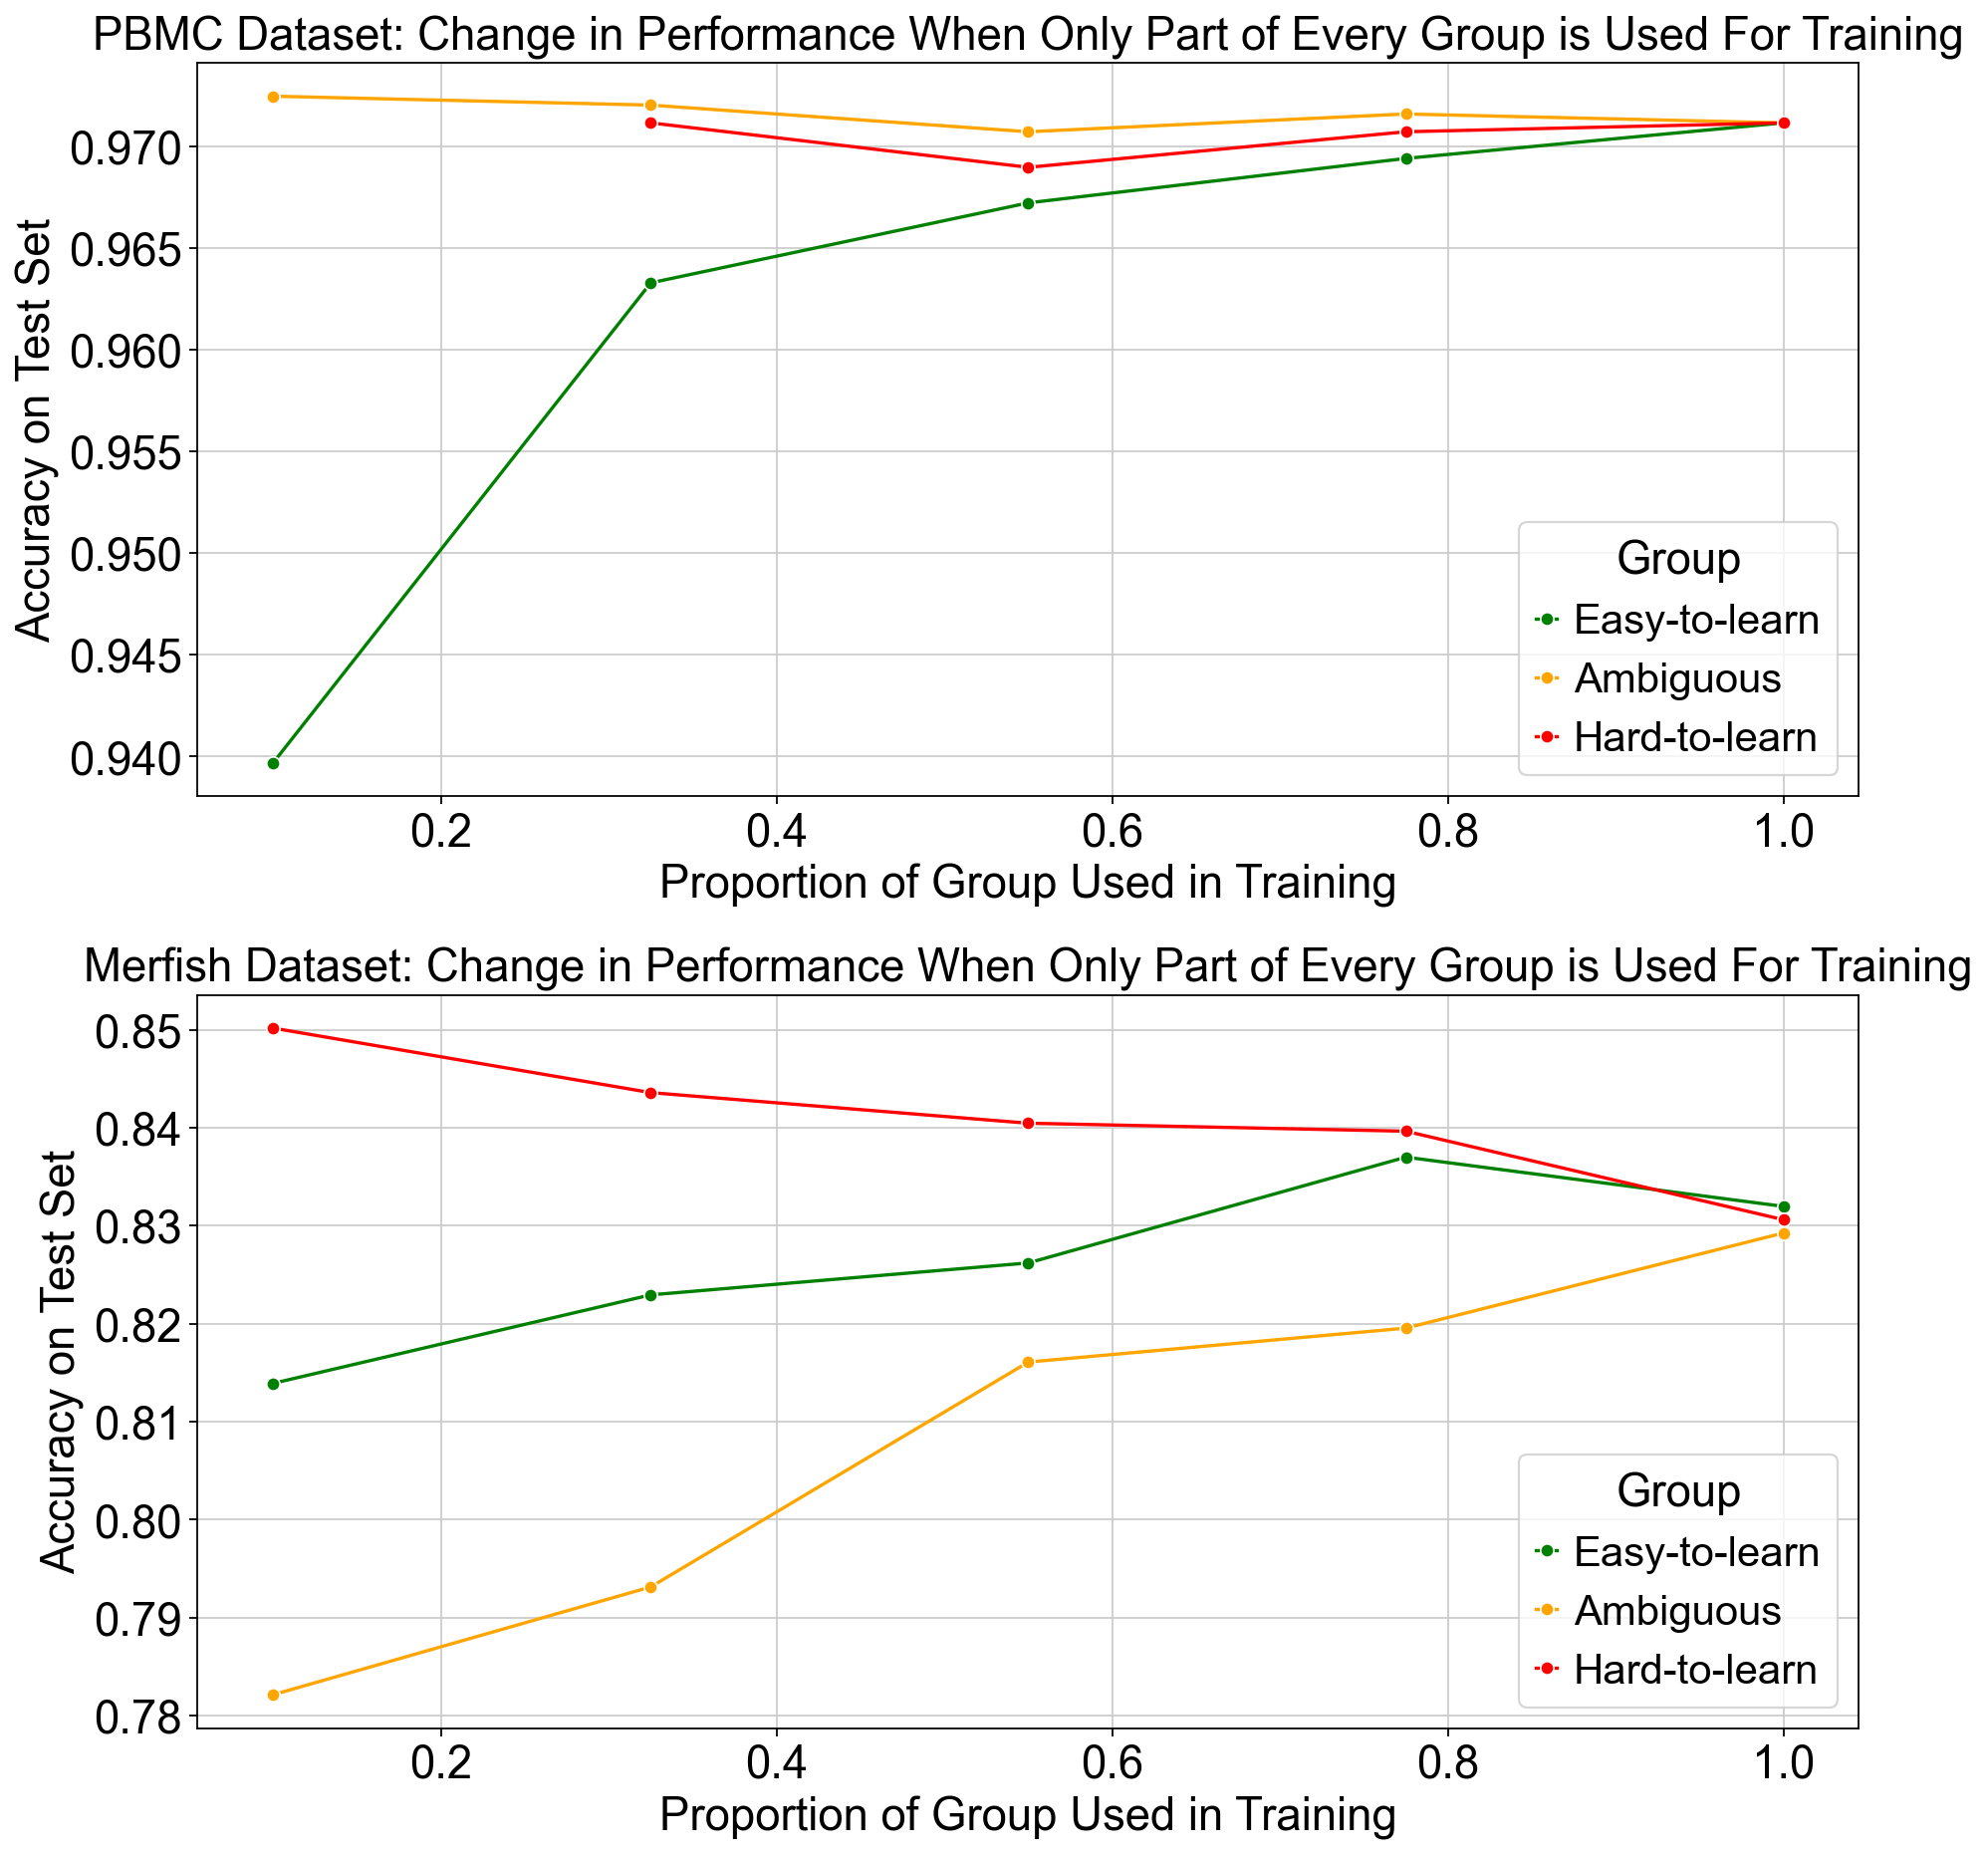

In [147]:
# Create the custom palette
palette = dict(zip(annotation_order, annotation_colors))

# Combine results from both datasets
results_combined = pd.concat([results_pbmc, results_merfish], ignore_index=True)

# Create a figure with two subplots stacked vertically
fig, axs = plt.subplots(2, 1, figsize=(12, 12), sharex=False)

# Plot for PBMC Dataset
sns.lineplot(
    data=results_pbmc,
    x='Proportion',
    y='Accuracy',
    hue='Group',
    marker='o',
    palette=palette,
    hue_order=annotation_order,
    ax=axs[0]
)
axs[0].set_title('PBMC Dataset: Change in Performance When Only Part of Every Group is Used For Training')
axs[0].set_xlabel('Proportion of Group Used in Training')
axs[0].set_ylabel('Accuracy on Test Set')

# Plot for Merfish Dataset
sns.lineplot(
    data=results_merfish,
    x='Proportion',
    y='Accuracy',
    hue='Group',
    marker='o',
    palette=palette,
    hue_order=annotation_order,
    ax=axs[1]
)
axs[1].set_title('Merfish Dataset: Change in Performance When Only Part of Every Group is Used For Training')
axs[1].set_xlabel('Proportion of Group Used in Training')
axs[1].set_ylabel('Accuracy on Test Set')

plt.tight_layout()
plt.show()

# Optimal Compositions

In [190]:
prob_list_merfish_new = train_and_get_prob_list(adata_merfish, label_key='CellType', epoch_num=150, device=device, batch_size=64)

# train and get conf and var of merfish
all_conf_merfish, all_var_merfish = calculate_confidence_and_variability(prob_list_merfish_new, n_obs=adata_merfish.n_obs, epoch_num=150)

# find cutoffs of merdish 
conf_cutoff, var_cutoff = find_cutoffs(adata_merfish, 'CellType', device, probability=0.1, percentile=90, epoch_num=150)

# Assign annotations
adata_merfish = assign_annotations(adata_merfish, all_conf_merfish, all_var_merfish, conf_cutoff, var_cutoff, annotation_col='Annotation')

# count the number of cells in each group
group_counts = adata_merfish.obs['Annotation'].value_counts()


[1,     2] loss: 0.467
[1,    12] loss: 2.349
[1,    22] loss: 2.297
[1,    32] loss: 2.257
[1,    42] loss: 2.206
[1,    52] loss: 2.196
[1,    62] loss: 2.140
[1,    72] loss: 2.105
[1,    82] loss: 2.039
[1,    92] loss: 1.998
[1,   102] loss: 1.906
[1,   112] loss: 1.855
[1,   122] loss: 1.788
[1,   132] loss: 1.702
[1,   142] loss: 1.634
[1,   152] loss: 1.536
[1,   162] loss: 1.422
[1,   172] loss: 1.357
[1,   182] loss: 1.269
[1,   192] loss: 1.177
[1,   202] loss: 1.080
[1,   212] loss: 1.044
[1,   222] loss: 0.975
[1,   232] loss: 0.901
[1,   242] loss: 0.921
[1,   252] loss: 0.804
[1,   262] loss: 0.809
[1,   272] loss: 0.742
[1,   282] loss: 0.698
[1,   292] loss: 0.731
[1,   302] loss: 0.691
[1,   312] loss: 0.682
[1,   322] loss: 0.668
[1,   332] loss: 0.647
[1,   342] loss: 0.583
[1,   352] loss: 0.588
[1,   362] loss: 0.608
[1,   372] loss: 0.580
[1,   382] loss: 0.588
[1,   392] loss: 0.577
[1,   402] loss: 0.587
[1,   412] loss: 0.577
[1,   422] loss: 0.607
[1,   432] 

In [192]:
group_counts = adata_merfish.obs['Annotation'].value_counts()
print(group_counts)

Annotation
Ambiguous        38724
Easy-to-learn    30967
Hard-to-learn     3951
Name: count, dtype: int64


In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from Annotatability.models import Net, is_scipy_cs_sparse, train_neural_net
import itertools
import contextlib
import io

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from Annotatability.models import Net, is_scipy_cs_sparse, train_neural_net
import itertools
import contextlib
import io

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from Annotatability.models import Net, is_scipy_cs_sparse, train_neural_net
import itertools
import contextlib
import io

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def find_optimal_compositions(
    adata,
    label_key,
    annotation_key,
    dataset_sizes,
    group_labels,
    step_size,
    max_epochs=40,  # Updated to 40 epochs
    batch_size=256,
    num_layers=3,
    device='cpu'
):
    # Initialize label encoder
    label_encoder = LabelEncoder()
    y_full = adata.obs[label_key].values
    label_encoder.fit(y_full)
    num_classes = len(label_encoder.classes_)

    # Separate indices by group
    group_indices = {
        group: np.where(adata.obs[annotation_key] == group)[0]
        for group in group_labels
    }

    # Determine the maximum number of samples available for each group
    max_samples_per_group = {group: len(indices) for group, indices in group_indices.items()}

    # Debug: Print max_samples_per_group to verify correctness
    print("Maximum Samples Per Group:")
    for group in group_labels:
        print(f"{group}: {max_samples_per_group[group]}")

    # Prepare to store results
    results = []

    for size in tqdm(dataset_sizes, desc='Processing Dataset Sizes'):
        min_loss = float('inf')
        optimal_comp = None

        # Generate possible counts for each group
        possible_counts = {}
        for group in group_labels:
            max_count = min(size, max_samples_per_group[group])
            possible_counts[group] = list(range(0, max_count + 1, step_size))
            # Ensure that max_count is included if it's not a multiple of step_size
            if max_count % step_size != 0 and max_count not in possible_counts[group]:
                possible_counts[group].append(max_count)

        # Debug: Print possible counts for each group at this dataset size
        print(f"\nDataset Size: {size}")
        for group in group_labels:
            print(f"Possible counts for {group}: {possible_counts[group]}")

        # Generate all combinations of counts that sum to 'size'
        compositions = []
        for counts in itertools.product(*[possible_counts[group] for group in group_labels]):
            comp = dict(zip(group_labels, counts))
            total = sum(comp.values())
            if total == size:
                compositions.append(comp)

        # Debug: Print number of compositions generated
        print(f"Number of compositions for size {size}: {len(compositions)}")

        # Evaluate each composition
        for comp in compositions:
            try:
                # Check if composition is feasible
                feasible = all(comp[group] <= max_samples_per_group[group] for group in group_labels)
                if not feasible:
                    print(f"Skipping infeasible composition: {comp}")
                    continue

                # **Assertion to enforce group count constraints**
                assert comp['Hard-to-learn'] <= max_samples_per_group['Hard-to-learn'], \
                    f"'Hard-to-learn' count {comp['Hard-to-learn']} exceeds maximum {max_samples_per_group['Hard-to-learn']}"

                # Prepare data according to the composition
                indices = []
                for group in group_labels:
                    group_idx = group_indices[group]
                    count = comp[group]
                    if count > 0:
                        selected_indices = group_idx[:count]  # Deterministically select the first 'count' samples
                        indices.extend(selected_indices)
                indices = np.array(indices)

                # Ensure that we have enough samples
                if len(indices) != size:
                    print(f"Mismatch in counts for composition {comp}: expected {size}, got {len(indices)}")
                    continue

                # Prepare training data
                X_train = adata.X[indices]
                y_train = adata.obs[label_key].values[indices]
                y_train_encoded = label_encoder.transform(y_train)

                # Initialize the model
                input_dim = X_train.shape[1]
                model = Net(input_size=input_dim, output_size=num_classes)
                model.to(device)

                # Prepare data for training
                x_data = X_train.toarray() if is_scipy_cs_sparse(X_train) else np.array(X_train)
                tensor_x = torch.Tensor(x_data).to(device)
                tensor_y = torch.LongTensor(y_train_encoded).to(device)
                train_dataset = torch.utils.data.TensorDataset(tensor_x, tensor_y)
                trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

                # Define criterion and optimizer
                criterion = nn.CrossEntropyLoss()
                optimizer = optim.Adam(model.parameters(), lr=1e-3)

                # Suppress training prints
                f = io.StringIO()
                with contextlib.redirect_stdout(f):
                    # Train the model
                    model = train_neural_net(model, device, trainloader, criterion, optimizer, epoch_num=max_epochs)

                # Evaluate loss on training data
                model.eval()
                with torch.no_grad():
                    outputs = model(tensor_x)
                    loss = criterion(outputs, tensor_y)
                    loss_value = loss.item()

                # Debug: Print composition and loss
                print(f"Composition: {comp}, Loss: {loss_value}")

                # Keep track of the composition with the minimum loss
                if loss_value < min_loss:
                    min_loss = loss_value
                    optimal_comp = comp.copy()
                    optimal_comp['Loss'] = min_loss

                # Clean up
                del model, optimizer, criterion, train_dataset, trainloader, tensor_x, tensor_y
                torch.cuda.empty_cache()

            except AssertionError as ae:
                print(f"Assertion Error: {ae}")
                continue
            except Exception as e:
                print(f"Error with composition {comp}: {e}")
                continue

        if optimal_comp is not None:
            optimal_comp['Dataset Size'] = size
            results.append(optimal_comp)
        else:
            print(f"No feasible compositions for dataset size {size}")

    # Create DataFrame from results
    optimal_compositions_df = pd.DataFrame(results)
    # Reorder columns
    columns_order = ['Dataset Size'] + group_labels + ['Loss']
    optimal_compositions_df = optimal_compositions_df[columns_order]
    return optimal_compositions_df
    
# Determine total number of cells in the dataset
total_cells = adata_merfish.n_obs  # Replace with your dataset variable

# Define dataset sizes dynamically
min_size = 100
max_size = 10000
step_dataset_size = max(total_cells // 20, 1000)  # Adjust step size based on dataset size

dataset_sizes = list(range(min_size, max_size + 1, step_dataset_size))

# Ensure the last dataset size is the total number of cells
if dataset_sizes[-1] != max_size:
    dataset_sizes.append(max_size)

# Define group labels and step size
group_labels = ['Easy-to-learn', 'Ambiguous', 'Hard-to-learn']
step_size = 500  # Adjust as needed

# For merfish Dataset
optimal_compositions_merfish = find_optimal_compositions(
    adata=adata_merfish,
    label_key='CellType',
    annotation_key='Annotation',  # Replace with the correct key
    dataset_sizes=dataset_sizes,
    group_labels=group_labels,
    step_size=step_size,
    max_epochs=40,  # Updated to 40 epochs
    batch_size=256,
    device=device
)

# Prepare data for visualization
optimal_compositions_merfish_melted = optimal_compositions_merfish.melt(
    id_vars=['Dataset Size', 'Loss'],
    value_vars=group_labels,
    var_name='Group',
    value_name='Count'
)

Maximum Samples Per Group:
Easy-to-learn: 30967
Ambiguous: 38724
Hard-to-learn: 3951


Processing Dataset Sizes:  25%|██▌       | 1/4 [00:00<00:00,  9.03it/s]


Dataset Size: 100
Possible counts for Easy-to-learn: [0, 100]
Possible counts for Ambiguous: [0, 100]
Possible counts for Hard-to-learn: [0, 100]
Number of compositions for size 100: 3
Composition: {'Easy-to-learn': 0, 'Ambiguous': 0, 'Hard-to-learn': 100}, Loss: 0.4284009039402008
Composition: {'Easy-to-learn': 0, 'Ambiguous': 100, 'Hard-to-learn': 0}, Loss: 0.32509803771972656
Composition: {'Easy-to-learn': 100, 'Ambiguous': 0, 'Hard-to-learn': 0}, Loss: 0.10210693627595901

Dataset Size: 3782
Possible counts for Easy-to-learn: [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 3782]
Possible counts for Ambiguous: [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 3782]
Possible counts for Hard-to-learn: [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 3782]
Number of compositions for size 3782: 3
Composition: {'Easy-to-learn': 0, 'Ambiguous': 0, 'Hard-to-learn': 3782}, Loss: 0.27655577659606934
Composition: {'Easy-to-learn': 0, 'Ambiguous': 3782, 'Hard-to-learn': 0}, Loss: 0.20715026557445526


Processing Dataset Sizes:  50%|█████     | 2/4 [00:02<00:03,  1.59s/it]

Composition: {'Easy-to-learn': 3782, 'Ambiguous': 0, 'Hard-to-learn': 0}, Loss: 0.0015699242940172553

Dataset Size: 7464
Possible counts for Easy-to-learn: [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7464]
Possible counts for Ambiguous: [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7464]
Possible counts for Hard-to-learn: [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 3951]
Number of compositions for size 7464: 2
Composition: {'Easy-to-learn': 0, 'Ambiguous': 7464, 'Hard-to-learn': 0}, Loss: 0.1911424994468689


Processing Dataset Sizes:  75%|███████▌  | 3/4 [00:06<00:02,  2.57s/it]

Composition: {'Easy-to-learn': 7464, 'Ambiguous': 0, 'Hard-to-learn': 0}, Loss: 0.0006402409635484219

Dataset Size: 10000
Possible counts for Easy-to-learn: [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]
Possible counts for Ambiguous: [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]
Possible counts for Hard-to-learn: [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 3951]
Number of compositions for size 10000: 140
Composition: {'Easy-to-learn': 0, 'Ambiguous': 6500, 'Hard-to-learn': 3500}, Loss: 0.7181237936019897
Composition: {'Easy-to-learn': 0, 'Ambiguous': 7000, 'Hard-to-learn': 3000}, Loss: 0.8310362100601196
Composition: {'Easy-to-learn': 0, 'Ambiguous': 7500, 'Hard-to-learn': 2500}, Loss: 0.5648815631866455
Composition: {'Easy-to-learn': 0, 'Ambiguous': 8000, 'Hard-to-learn': 2000}, Loss: 0.6109257340431213
Composition: {'Easy-to-lea

In [197]:
# Check unique group labels in the Merfish dataset
unique_groups_merfish = adata_merfish.obs['Annotation'].unique()==group_labels = ['Easy-to-learn', 'Ambiguous', 'Hard-to-learn']

SyntaxError: cannot assign to comparison (2098913279.py, line 2)

Index(['Dataset Size', 'Easy-to-learn', 'Ambiguous', 'Hard-to-learn', 'Loss'], dtype='object')


<Figure size 1200x560 with 0 Axes>

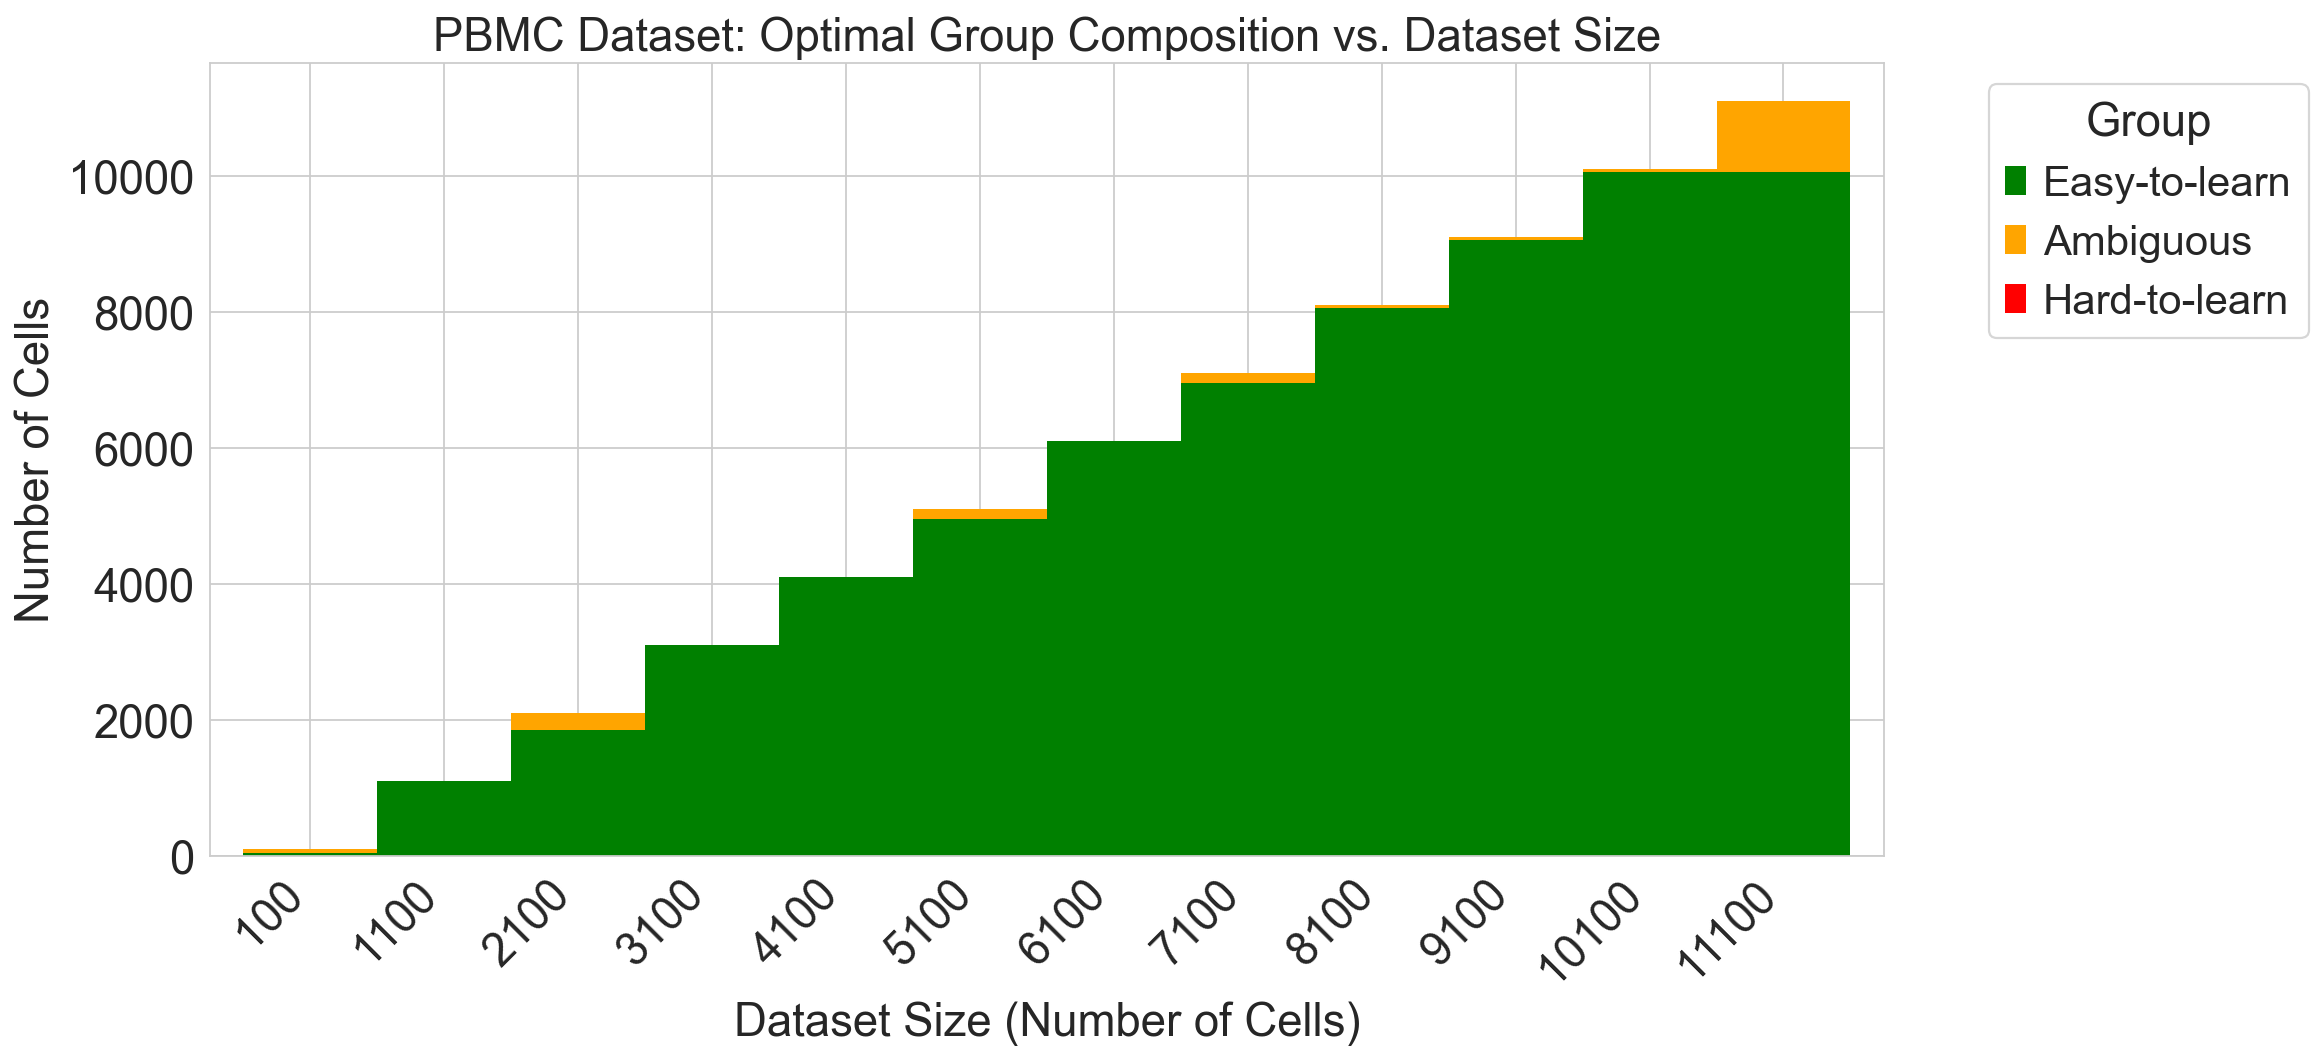

In [162]:
# Let's first check the columns of the optimal_compositions_pbmc DataFrame
print(optimal_compositions_merfish.columns)

# Prepare data for visualization
optimal_compositions_pbmc_melted = optimal_compositions_pbmc.melt(
    id_vars=['Dataset Size', 'Loss'],  # 'Dataset Size' and 'Loss' are not melted
    value_vars=['Easy-to-learn', 'Ambiguous', 'Hard-to-learn'],  # These are melted
    var_name='Group',  # This will create the 'Group' column
    value_name='Count'  # This will contain the counts
)

# Define custom color palette
palette = {'Easy-to-learn': 'green', 'Ambiguous': 'orange', 'Hard-to-learn': 'red'}

# Set the figure size and style
plt.figure(figsize=(15, 7))
sns.set_style("whitegrid")

# Pivot the data for stacked plotting
optimal_compositions_pbmc_pivot = optimal_compositions_pbmc_melted.pivot(
    index='Dataset Size', columns='Group', values='Count'
).fillna(0)

# Reorder the columns to match the group_labels order
optimal_compositions_pbmc_pivot = optimal_compositions_pbmc_pivot[['Easy-to-learn', 'Ambiguous', 'Hard-to-learn']]

# Plot the stacked bar chart
ax = optimal_compositions_pbmc_pivot.plot(
    kind='bar',
    stacked=True,
    color=[palette[group] for group in ['Easy-to-learn', 'Ambiguous', 'Hard-to-learn']],
    width=1.0,
    edgecolor='none',
    figsize=(15, 7)
)

# Adjust the plot
ax.set_title('PBMC Dataset: Optimal Group Composition vs. Dataset Size')
ax.set_ylabel('Number of Cells')
ax.set_xlabel('Dataset Size (Number of Cells)')
ax.legend(title='Group', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels(optimal_compositions_pbmc_pivot.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()